# Historical Launch Data Analysis & Model Comparison

This notebook demonstrates the full ML pipeline using the `sneaker_intel` package:
- Data loading & cleaning
- Feature engineering
- Model training & evaluation
- Ensemble model comparison

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sneaker_intel.data import load_dataset, DatasetType
from sneaker_intel.data.transformers import clean_price_columns, parse_dates
from sneaker_intel.features.pipeline import FeaturePipeline
from sneaker_intel.models.linear import LinearRegressionModel
from sneaker_intel.models.random_forest import RandomForestModel
from sneaker_intel.models.xgboost_model import XGBoostModel
from sneaker_intel.models.lightgbm_model import LightGBMModel
from sneaker_intel.models.ensemble import EnsembleModel
from sneaker_intel.evaluation.metrics import evaluate_model
from sneaker_intel.evaluation.comparison import compare_models
from sneaker_intel.evaluation.interpretability import compute_ensemble_importances
from sneaker_intel.visualization.style import apply_nike_style
from sneaker_intel.visualization.plots import (
    plot_actual_vs_predicted,
    plot_feature_importance,
    plot_model_comparison,
    plot_correlation_heatmap,
    plot_sales_over_time,
)
from sneaker_intel.config import settings

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

apply_nike_style()
print('Sneaker Intel loaded successfully!')

Sneaker Intel loaded successfully!


## 1. Load & Clean Data

In [2]:
df = load_dataset(DatasetType.STOCKX)
print(f'Raw shape: {df.shape}')
df.head()

Raw shape: (99956, 8)


,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/17,11.0,Rhode Island


In [3]:
df = clean_price_columns(df)
df = parse_dates(df)
print(f'Cleaned shape: {df.shape}')
df.dtypes

Cleaned shape: (99956, 8)


Order Date      datetime64[ns]
Brand                   object
Sneaker Name            object
Sale Price             float64
Retail Price           float64
Release Date    datetime64[ns]
Shoe Size              float64
Buyer Region            object
dtype: object

## 2. Exploratory Analysis

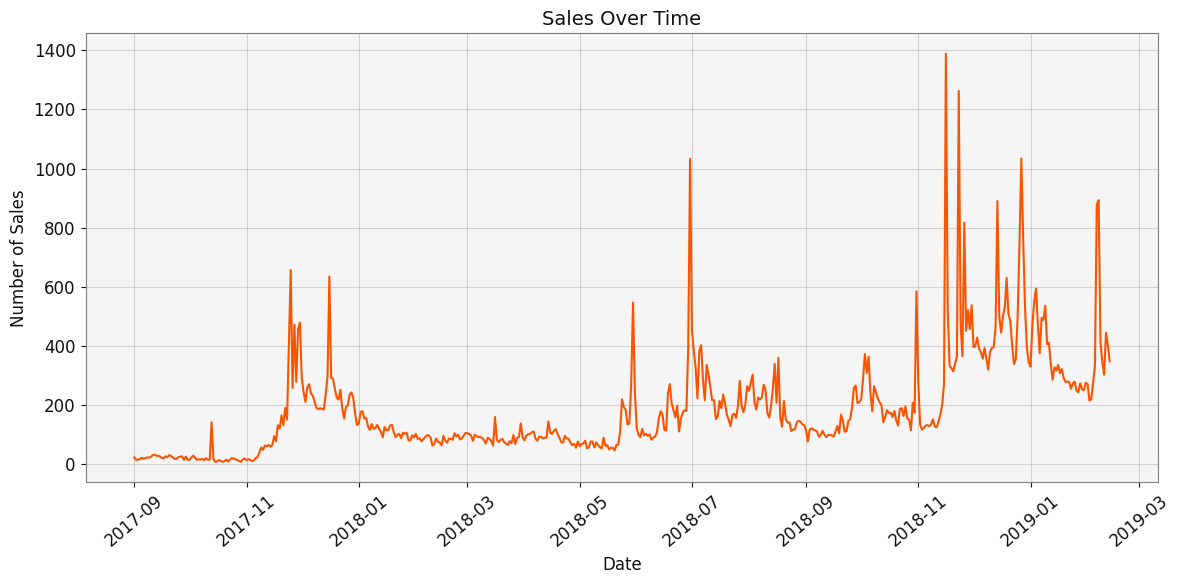

In [4]:
# Sales over time
plot_sales_over_time(df)
plt.tight_layout()
plt.show()

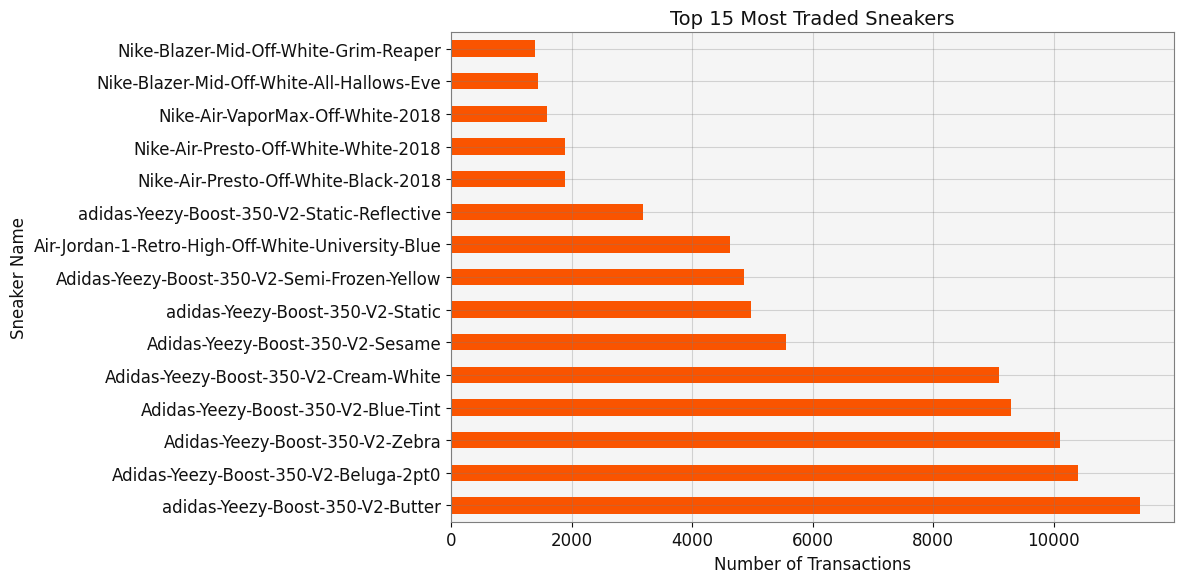

In [5]:
# Top 15 most traded sneakers
top = df.groupby('Sneaker Name')['Sale Price'].count().sort_values(ascending=False)[:15]
fig, ax = plt.subplots(figsize=(12, 6))
top.plot(kind='barh', ax=ax)
ax.set_title('Top 15 Most Traded Sneakers')
ax.set_xlabel('Number of Transactions')
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [6]:
pipeline = FeaturePipeline.stockx_default()
df = pipeline.transform(df)

# Add Number of Sales
df['Number of Sales'] = df['Order Date'].map(df['Order Date'].value_counts())

print(f'Features added: {len(pipeline.feature_names)}')
print(pipeline.feature_names)

Features added: 35
['Black', 'White', 'Grey', 'Red', 'Green', 'Neon', 'Orange', 'Tan/Brown', 'Pink', 'Blue', 'Colorful', 'yeezy350', 'airjordan', 'airforce', 'airmax90', 'airmax97', 'presto', 'vapormax', 'blazer', 'zoom', 'react', 'California', 'New York', 'Oregon', 'Florida', 'Texas', 'Other States', 'size_freq', 'Order Year', 'Order Month', 'Order Day', 'Release Year', 'Release Month', 'Release Day', 'days_since_release']


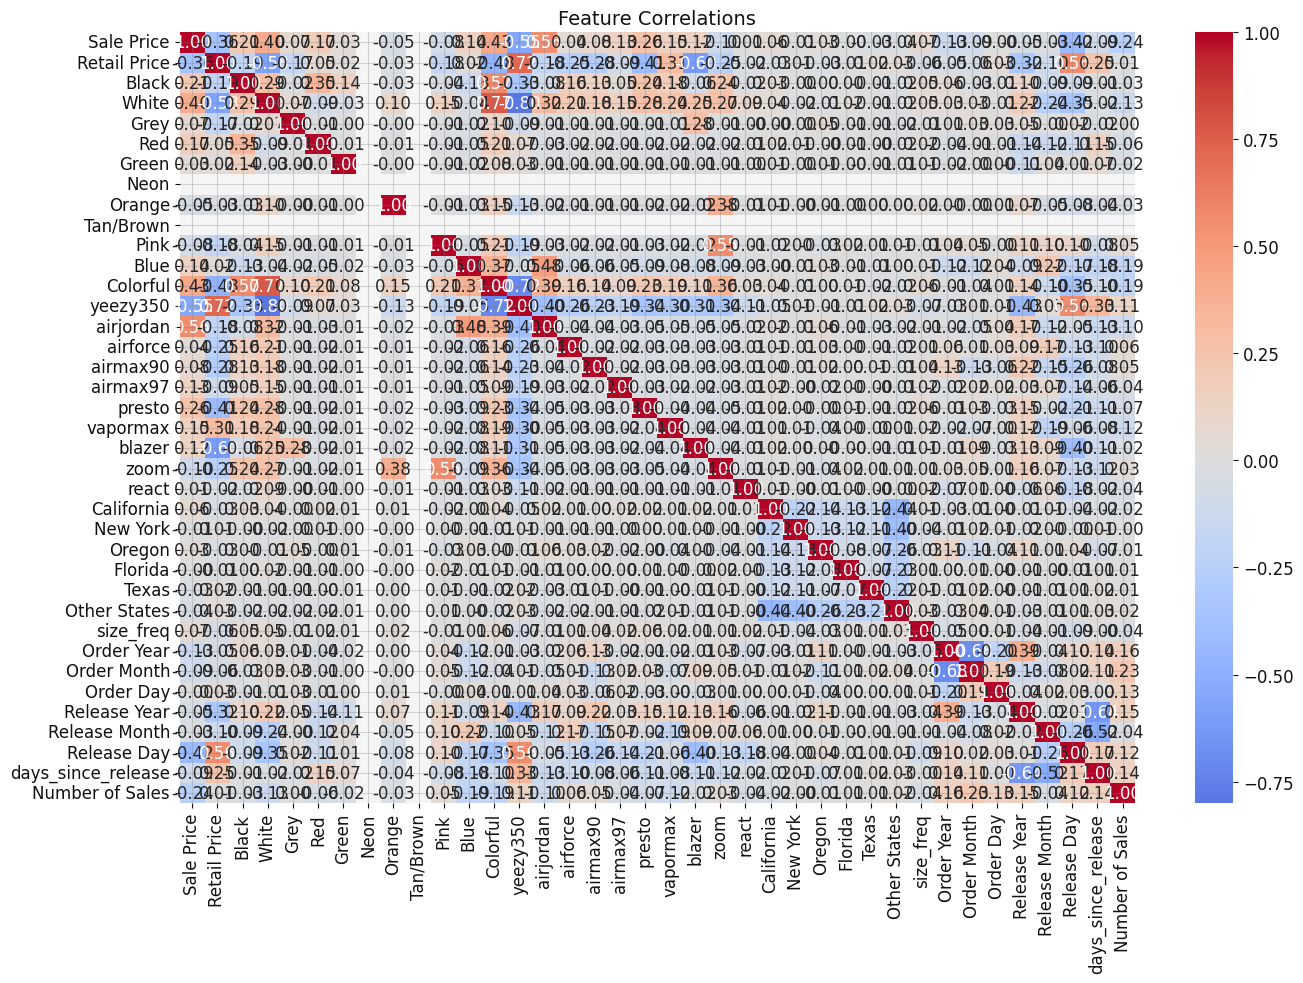

In [7]:
# Drop non-numeric columns for modeling
target = settings.features.target_column
drop_cols = ['Brand', 'Buyer Region', 'Shoe Size', 'Sneaker Name', 'Order Date', 'Release Date']
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Correlation heatmap
plot_correlation_heatmap(df_model, title='Feature Correlations')
plt.tight_layout()
plt.show()

## 4. Train/Test Split & Model Training

In [8]:
feature_cols = [c for c in df_model.columns if c != target]
X = df_model[feature_cols]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=settings.features.random_state
)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (79964, 37), Test: (19992, 37)


In [9]:
# Train all models
models = [
    LinearRegressionModel(),
    RandomForestModel(),
    XGBoostModel(),
    LightGBMModel(),
]

metrics_list = []
for model in models:
    model.fit(X_train, y_train)
    m = evaluate_model(model, X_test, y_test)
    metrics_list.append(m)
    print(f'{model.name}: MAE={m.mae:.2f}, R2={m.r2:.4f}')

Linear Regression: MAE=81.96, R2=0.7323


Random Forest: MAE=16.56, R2=0.9781


XGBoost: MAE=49.47, R2=0.9007


LightGBM: MAE=31.39, R2=0.9534


In [10]:
# Ensemble
ensemble = EnsembleModel(models=[models[1], models[2], models[3]])  # RF + XGB + LGBM
ensemble.fit(X_train, y_train)
ensemble_metrics = evaluate_model(ensemble, X_test, y_test)
metrics_list.append(ensemble_metrics)
print(f'Ensemble: MAE={ensemble_metrics.mae:.2f}, R2={ensemble_metrics.r2:.4f}')

Ensemble: MAE=29.17, R2=0.9589


## 5. Model Comparison

In [11]:
comparison = compare_models(metrics_list)
comparison.style.background_gradient(cmap='coolwarm')

,Model,MAE,MSE,RMSE,R2,CV MAE
0,Random Forest,16.560000,1413.370000,37.590000,0.978100,None
1,Ensemble,29.170000,2660.610000,51.580000,0.958900,None
2,LightGBM,31.390000,3014.020000,54.900000,0.953400,None
3,XGBoost,49.470000,6422.550000,80.140000,0.900700,None
4,Linear Regression,81.960000,17310.490000,131.570000,0.732300,None


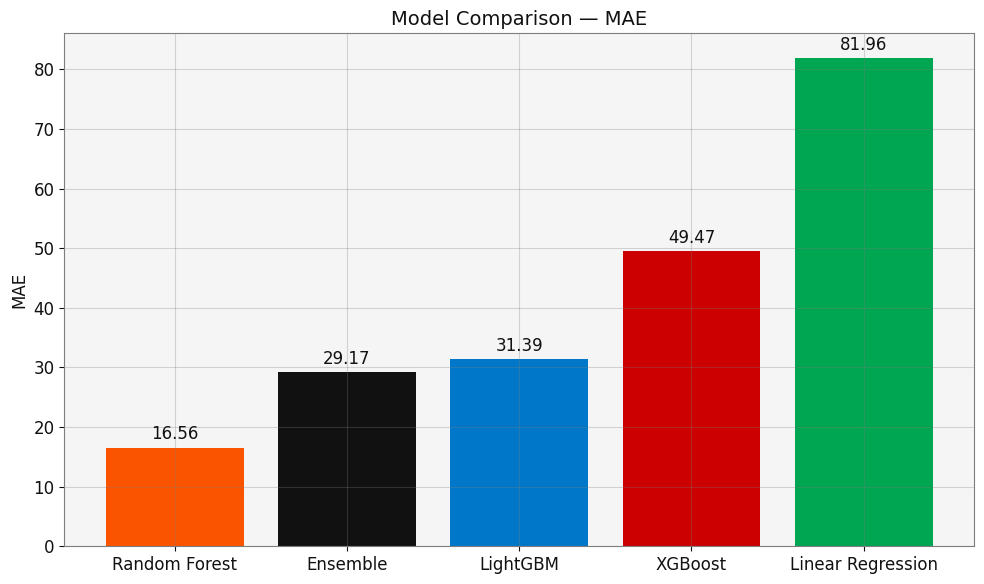

In [12]:
plot_model_comparison(comparison, metric='MAE')
plt.tight_layout()
plt.show()

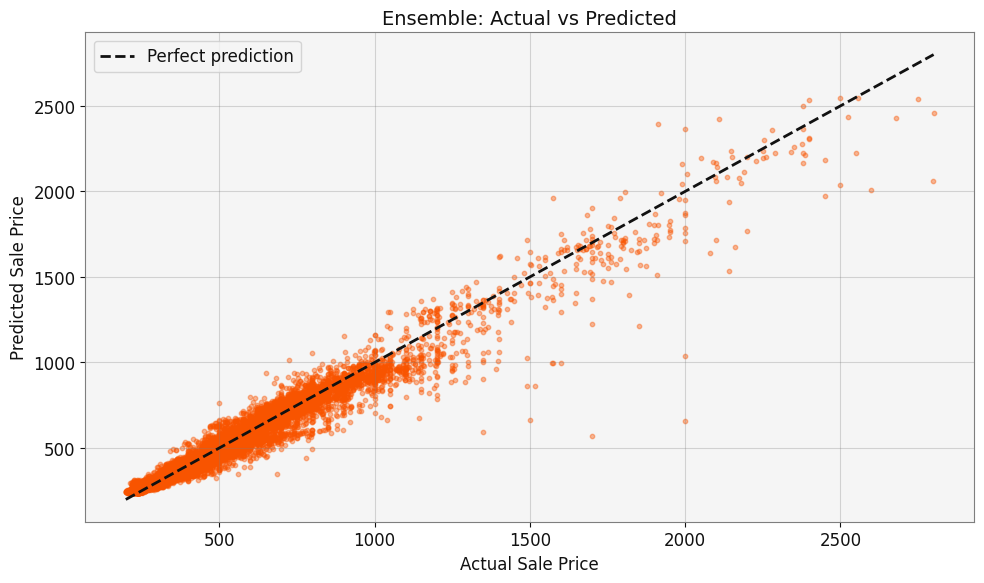

In [13]:
# Actual vs Predicted for ensemble
y_pred = ensemble.predict(X_test)
plot_actual_vs_predicted(y_test, y_pred, title='Ensemble: Actual vs Predicted')
plt.tight_layout()
plt.show()

## 6. Feature Importance

In [14]:
importances_df = compute_ensemble_importances(
    [models[1], models[2], models[3]],  # RF, XGB, LGBM
    feature_cols,
)
importances_df

,Feature,Importance_Random Forest,Importance_XGBoost,Importance_LightGBM,Average_Importance
0,airjordan,0.309146,0.137942,0.028667,0.158585
1,yeezy350,0.053586,0.389744,0.017000,0.153443
2,Release Day,0.214673,0.022768,0.098667,0.112036
3,days_since_release,0.084499,0.009153,0.207000,0.100217
4,Blue,0.050503,0.117180,0.022333,0.063339
5,size_freq,0.028352,0.001904,0.143667,0.057974
6,zoom,0.036586,0.115519,0.013333,0.055146
7,Release Year,0.068289,0.033208,0.049333,0.050277
8,Number of Sales,0.020737,0.016408,0.079000,0.038715
9,Order Month,0.014222,0.009758,0.065667,0.029882


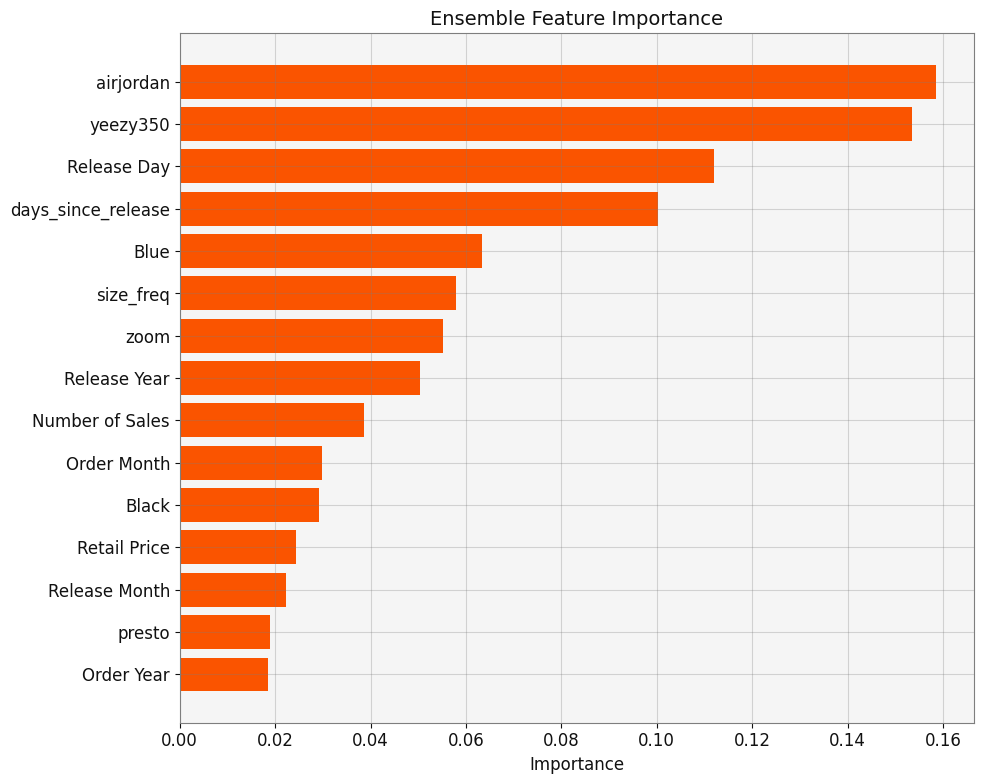

In [15]:
imp = ensemble.feature_importances
if imp is not None:
    plot_feature_importance(feature_cols, imp, top_n=15, title='Ensemble Feature Importance')
    plt.tight_layout()
    plt.show()